In [2]:
import pandas as pd
import os
import requests
import json
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [4]:
from preprocessing_utils import preprocess_NVD_data

In [5]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# EPSS data

Download the EPSS data from https://www.first.org/epss/data_stats into `data` folder

### <font color='blue'><b><i>TODO</i></b></font>:
- in the following cell, replace `epss_scores-2025-09-30.csv.gz` with the correct updated file (`epss_scores-2025-10-01.csv.gz`)

In [6]:
epss_current = pd.read_csv(os.path.join(data_path, 'epss_scores-2025-10-01.csv.gz'), compression='gzip', header=1)
epss_current # a Python statement with a variable name at the end of a cell will display its contents below


,cve,epss,percentile
0,CVE-1999-0001,0.01141,0.77780
1,CVE-1999-0002,0.10742,0.93087
2,CVE-1999-0003,0.90362,0.99589
3,CVE-1999-0004,0.03215,0.86596
4,CVE-1999-0005,0.25334,0.96035
...,...,...,...
296328,CVE-2025-9994,0.00060,0.19138
296329,CVE-2025-9996,0.00179,0.40027
296330,CVE-2025-9997,0.00182,0.40386
296331,CVE-2025-9998,0.00023,0.04753


# NVD data

In [7]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z' # Do NOT change these dates
date_end_NVD   = '2025-10-01T00:00:00.000Z' # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1 

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)

1000
2000
3000
4000
5000


In [8]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus']!='Reserved') & (df['cve.vulnStatus']!='Reject')]

# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id", right_on="cve", how="left")

In [9]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)
    
# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_09.csv"))

# Exploratory Data Analysis

- display some examples (e.g., the first two CVE records)

In [10]:
df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cve.id,CVE-2025-9751,CVE-2025-9752,CVE-2025-9753,CVE-2025-9754,CVE-2025-9755,CVE-2025-9756,CVE-2025-9567,CVE-2025-9568,CVE-2025-9569,CVE-2025-9757,CVE-2025-7405,CVE-2025-7731,CVE-2025-9570,CVE-2025-9758,CVE-2025-9759,CVE-2025-9760,CVE-2025-9761,CVE-2025-9763,CVE-2025-20703,CVE-2025-20704
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,twcert@cert.org.tw,twcert@cert.org.tw,twcert@cert.org.tw,cna@vuldb.com,Mitsubishielectric.Psirt@yd.MitsubishiElectric...,Mitsubishielectric.Psirt@yd.MitsubishiElectric...,twcert@cert.org.tw,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,cna@vuldb.com,security@mediatek.com,security@mediatek.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000,2025-09-01 01:15:47.060000,2025-09-01 02:15:45.223000,2025-09-01 02:15:45.493000,2025-09-01 02:15:45.713000,2025-09-01 03:15:32.337000,2025-09-01 03:15:32.570000,2025-09-01 03:15:32.767000,2025-09-01 03:15:32.967000,2025-09-01 04:15:45.110000,2025-09-01 04:15:51.357000,2025-09-01 04:15:51.600000,2025-09-01 04:15:51.843000,2025-09-01 04:15:53.650000,2025-09-01 05:15:41.997000,2025-09-01 05:15:42.863000,2025-09-01 05:15:43.090000,2025-09-01 06:15:33.357000,2025-09-01 06:15:34.630000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000,2025-09-04 18:46:50.757000,2025-09-04 18:46:58.453000,2025-09-05 19:54:52.480000,2025-09-08 14:02:39.200000,2025-09-25 14:18:08.317000,2025-09-25 14:18:31.453000,2025-09-25 14:18:03.243000,2025-09-08 13:54:13.633000,2025-09-02 15:55:25.420000,2025-09-02 15:55:25.420000,2025-09-25 14:18:25.953000,2025-09-11 21:16:26.307000,2025-09-08 13:53:29.567000,2025-09-27 00:28:31.297000,2025-09-08 13:45:56.043000,2025-09-08 13:40:09.430000,2025-09-03 16:07:38.867000,2025-09-03 16:07:22.770000
cve.vulnStatus,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Awaiting Analysis,Awaiting Analysis,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...,[{'url': 'https://github.com/Yashh-G/zero-day-...,[{'url': 'https://github.com/Yashh-G/zero-day-...,[{'url': 'https://gist.github.com/0xSebin/147e...,[{'url': 'https://github.com/CSentinel/CVE/iss...,[{'url': 'https://www.twcert.org.tw/en/cp-139-...,[{'url': 'https://www.twcert.org.tw/en/cp-139-...,[{'url': 'https://www.twcert.org.tw/en/cp-139-...,[{'url': 'https://github.com/lrjbsyh/CVE_Hunte...,"[{'url': 'https://jvn.jp/vu/JVNVU90041458/', '...","[{'url': 'https://jvn.jp/vu/JVNVU90041458/', '...",[{'url': 'https://www.twcert.org.tw/en/cp-139-...,[{'url': 'https://gist.github.com/0xSebin/29cb...,[{'url': 'https://github.com/lrjbsyh/CVE_Hunte...,[{'url': 'https://github.com/marcelomulder/CVE...,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/gggg6886/CVE/issu...,[{'url': 'https://corp.mediatek.com/product-se...,[{'url': 'https://corp.mediatek.com/product-se...
cve.cisaExploitAdd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cve.cisaActionDue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cve.cisaRequiredAction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- show a bar plot with the daily volume of published CVEs

cve.published
2025-09-01     84
2025-09-02    136
2025-09-03    184
2025-09-04    276
2025-09-05    235
2025-09-06     61
2025-09-07     17
2025-09-08     92
2025-09-09    351
2025-09-10     96
2025-09-11    155
2025-09-12     93
2025-09-13     15
2025-09-14     35
2025-09-15    409
2025-09-16    232
2025-09-17    216
2025-09-18    200
2025-09-19    121
2025-09-20     14
2025-09-21     17
2025-09-22    415
2025-09-23    128
2025-09-24    125
2025-09-25    107
2025-09-26    200
2025-09-27     52
2025-09-28     36
2025-09-29    114
2025-09-30    109
Name: count, dtype: int64


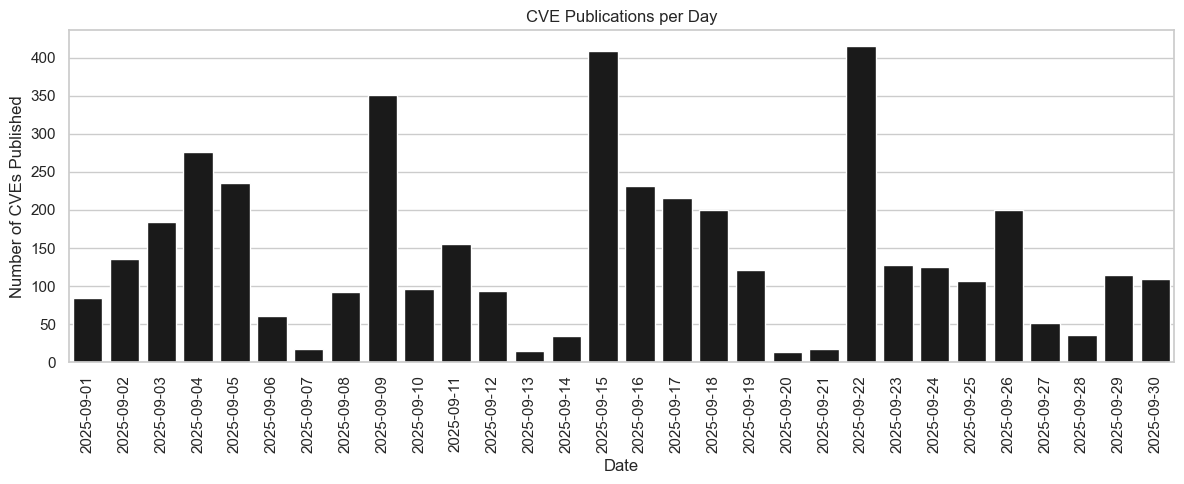

In [11]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

print(published_counts)

plt.figure(figsize=(12, 5))
sns.barplot(x=published_counts.index, y=published_counts.values, color="k" )
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()

In [12]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cve.id                      4325 non-null   object        
 1   cve.sourceIdentifier        4325 non-null   object        
 2   cve.published               4325 non-null   datetime64[ns]
 3   cve.lastModified            4325 non-null   datetime64[ns]
 4   cve.vulnStatus              4325 non-null   object        
 5   cve.references              4325 non-null   object        
 6   cve.cisaExploitAdd          9 non-null      object        
 7   cve.cisaActionDue           9 non-null      object        
 8   cve.cisaRequiredAction      9 non-null      object        
 9   cve.cisaVulnerabilityName   9 non-null      object        
 10  description                 4325 non-null   object        
 11  vulnerable_cpes             4325 non-null   object      

- print the description of the last ten published vulnerabilities

In [13]:
for idx, x in enumerate(df.sort_values('cve.published', ascending=False)[:10].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['cve.published'])
    print(x[1].description)


----------------------------------------------------------------------------------------------------
CVE-2025-61792 2025-09-30 23:15:29.700000
Quadient DS-700 iQ devices through 2025-09-30 might have a race condition during the quick clicking of (in order) the Question Mark button, the Help Button, the About button, and the Help Button, leading to a transition out of kiosk mode into local administrative access. NOTE: the reporter indicates that the "behavior was observed sporadically" during "limited time on the client site," making it not "possible to gain more information about the specific kiosk mode crashing issue," and the only conclusion was "there appears to be some form of race condition." Accordingly, there can be doubt that a reproducible cybersecurity vulnerability was identified; sporadic software crashes can also be caused by a hardware fault on a single device (for example, transient RAM errors). The reporter also describes a variety of other issues, including initial acc

### <font color='blue'><b><i>TODO</i></b>: produce plots or tables to address the folowing points</font>
- what is the percentage of CVEs which received a CVSS score?
- report descriptive statistics of CVSS the CVSS base score and/or show its distribution
- report descriptive statistics of EPSS and/or show its distribution
- produce a scatter plot showing CVSS vs EPSS
- <b>be creative</b>!
    - How many vulnerabilities are published on CISA KEV? 
    - What are the the 20 most frequent vendors? (vendor name can be extracted from the `vulnerable_cpes` field).
    - What are the 20 most frequent CWEs?
    - Anaything else you see fit!

<font color='blue'>Use text cells to discuss the outcome after each point</font>

In [14]:
# plotting precentage of CVEs which received a CVSS score

total_CVEs = len(df)
cves_with_CVEs = len(df[df['cvss_baseScore'].notna()])

percentage_CVEs_with_CVSS = cves_with_CVEs / total_CVEs * 100

print(f"Total percentage CVEs with CVSS score = {percentage_CVEs_with_CVSS:.2f}%")


Total percentage CVEs with CVSS score = 77.32%


CVSS Statistics:
count    3344.000000
mean        6.906041
std         1.804292
min         2.200000
25%         5.400000
50%         6.500000
75%         8.200000
max        10.000000
Name: cvss_baseScore, dtype: float64
cvss_category
Low (0.0-3.9)           119
Medium (4.0-6.9)       1616
High (7.0-8.9)         1114
Critical (9.0-10.0)     495
Name: count, dtype: int64


C:\Users\lucas\AppData\Local\Temp\ipykernel_2984\1912575591.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts_ordered.index, y=category_counts_ordered.values,


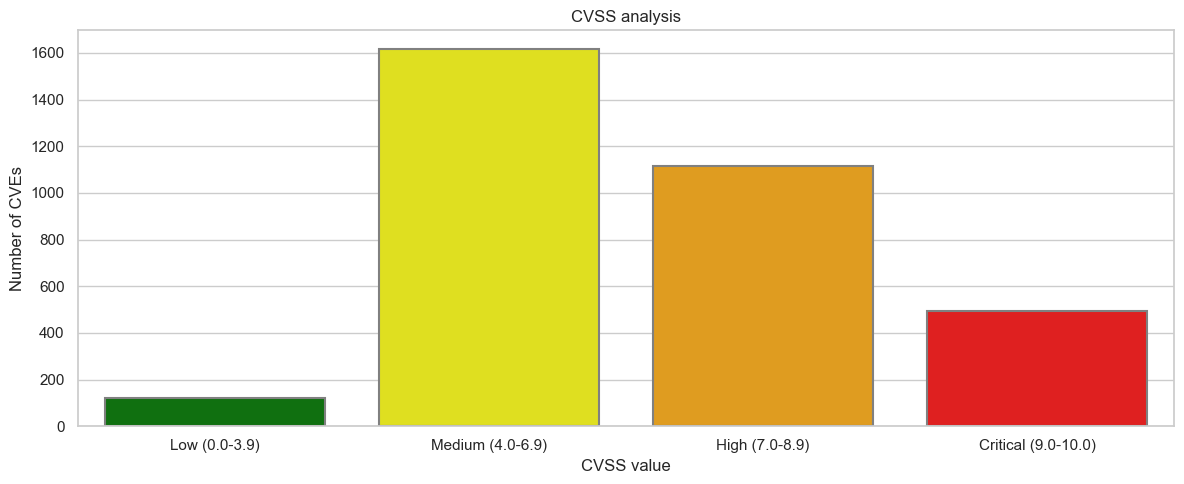

In [15]:
# report descriptive statistics of CVSS the CVSS base score and/or show its distribution

print("CVSS Statistics:")
print(df['cvss_baseScore'].describe())

# desired index order
desired_order = ['Low (0.0-3.9)', 'Medium (4.0-6.9)', 'High (7.0-8.9)', 'Critical (9.0-10.0)']

# Create CVSS severity categories
def categorize_cvss(score):
    if 0.0 <= score <= 3.9:
        return 'Low (0.0-3.9)'
    elif 4.0 <= score <= 6.9:
        return 'Medium (4.0-6.9)'
    elif 7.0 <= score <= 8.9:
        return 'High (7.0-8.9)'
    elif 9.0 <= score <= 10.0:
        return 'Critical (9.0-10.0)'
    else:
        return 'Unknown'

# Apply categorization
df['cvss_category'] = df['cvss_baseScore'].apply(categorize_cvss)

# Count by category
category_counts = df['cvss_category'].value_counts()

# Reindex the category_counts with the desired order
category_counts_ordered = category_counts.reindex(desired_order)

# Remove any NaN values (categories that don't exist in your data)
category_counts_ordered = category_counts_ordered.dropna()

print(category_counts_ordered)

colors = ['green', 'yellow', 'orange', 'red']

plt.figure(figsize=(12, 5))
sns.barplot(x=category_counts_ordered.index, y=category_counts_ordered.values, 
           palette = colors, 
           edgecolor="grey", 
           linewidth=1.5)     
plt.xticks(rotation=0)
plt.xlabel("CVSS value")
plt.ylabel("Number of CVEs")
plt.title("CVSS analysis")
plt.tight_layout()
plt.show()

#plt.pie(data = category_counts_ordered.index, labels = category_counts_ordered.values, colors = colors)
#plt.show()

EPSS Statistics:
count    4325.000000
mean        0.001476
std         0.017279
min         0.000020
25%         0.000240
50%         0.000320
75%         0.000470
max         0.810640
Name: epss, dtype: float64


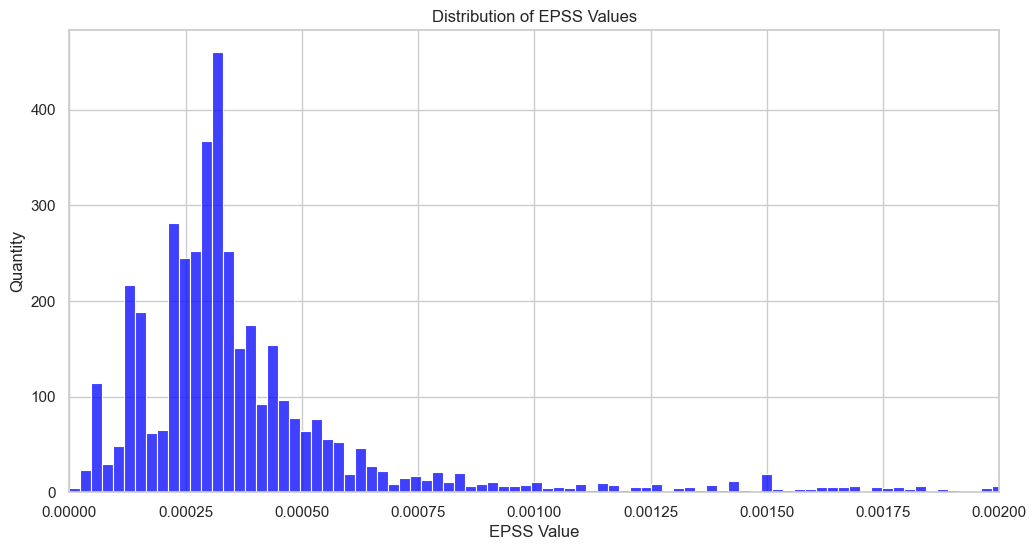

In [16]:
# report descriptive statistics of EPSS and/or show its distribution

print("EPSS Statistics:")
print(df['epss'].describe())

plt.figure(figsize=(12, 6))
plt.xlim(0, 0.002)
sns.histplot(df["epss"], color="blue", binrange=[0,0.003])
plt.xlabel("EPSS Value")
plt.ylabel("Quantity")
plt.title("Distribution of EPSS Values")
plt.show()



EPSS Statistics:
count    3344.000000
mean        0.001752
std         0.019632
min         0.000020
25%         0.000260
50%         0.000340
75%         0.000490
max         0.810640
Name: epss, dtype: float64


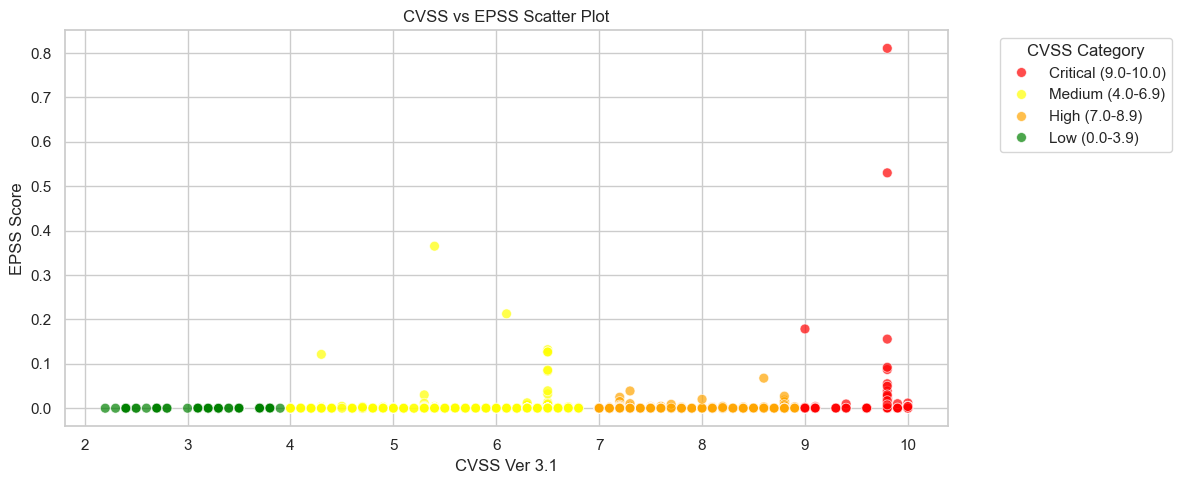

In [17]:
# Create scatter plot showing CVSS vs EPSS

# Filter out missing values first
scatter_data = df.dropna(subset=['cvss_baseScore', 'epss', 'cvss_category'])

# Print basic statistics
print("EPSS Statistics:")
print(scatter_data['epss'].describe())

plt.figure(figsize=(12, 5))
sns.scatterplot(data=scatter_data,
                x='cvss_baseScore',
                y='epss', 
                hue='cvss_category',
                palette={'Low (0.0-3.9)': 'green', 
                        'Medium (4.0-6.9)': 'yellow', 
                        'High (7.0-8.9)': 'orange', 
                        'Critical (9.0-10.0)': 'red'},
                alpha=0.7,
                s=50)

plt.xlabel("CVSS Ver 3.1")
plt.ylabel("EPSS Score")
plt.title("CVSS vs EPSS Scatter Plot")
plt.legend(title='CVSS Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### CVSS vs EPSS Scatter Plot Analysis

The scatter plot below shows the relationship between CVSS Base Score (x-axis) and EPSS Score (y-axis). This visualization helps us understand:
- Whether higher CVSS scores correlate with higher exploitation probability (EPSS)
- The distribution and clustering patterns of vulnerabilities
- Outliers that might have high CVSS but low EPSS (or vice versa)

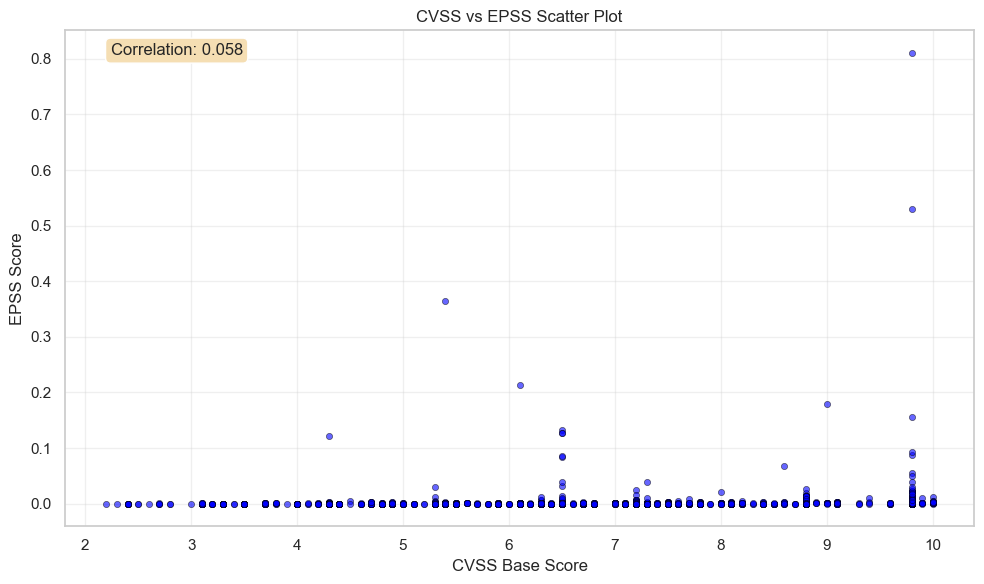

Number of CVEs with both CVSS and EPSS scores: 3344
Correlation between CVSS and EPSS: 0.058
CVSS range: 2.2 - 10.0
EPSS range: 0.000020 - 0.810640


In [24]:
# Create scatter plot showing CVSS vs EPSS
plt.figure(figsize=(10, 6))

# Filter out rows where either CVSS or EPSS is missing
scatter_data = df.dropna(subset=['cvss_baseScore', 'epss'])

# Create the scatter plot
plt.scatter(scatter_data['cvss_baseScore'], scatter_data['epss'], 
           alpha=0.6, s=20, color='blue', edgecolors='black', linewidth=0.5)

plt.xlabel('CVSS Base Score')
plt.ylabel('EPSS Score')
plt.title('CVSS vs EPSS Scatter Plot')
plt.grid(True, alpha=0.3)

# Add some statistics
correlation = scatter_data['cvss_baseScore'].corr(scatter_data['epss'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

plt.tight_layout()
plt.show()

# Print some basic statistics
print(f"Number of CVEs with both CVSS and EPSS scores: {len(scatter_data)}")
print(f"Correlation between CVSS and EPSS: {correlation:.3f}")
print(f"CVSS range: {scatter_data['cvss_baseScore'].min():.1f} - {scatter_data['cvss_baseScore'].max():.1f}")
print(f"EPSS range: {scatter_data['epss'].min():.6f} - {scatter_data['epss'].max():.6f}")

# CVE selection


### <font color='blue'><b><i>TODO</i></b>
- Filter the CVEs with low EPSS (<1%)
- Select candidate CVEs
    - From the resulting subset, select 10 CVEs that you think will reach high EPSS by the end of the course.
    - Clearly describe the criteria you used for selection (e.g., high CVSS, popular software, CWE, popular vendor, number of references, keyword in description, manual inspection, random sampling, security blogs).
- Share the selected CVE ids with the instructor (by two weeks). Use the code cell below to produce the csv file to submit.
- Track the EPSS of your CVEs over time

# suggestion
- Possibly we may want to leverage:
    - threath intelligence systems are biased towards the sensor networks (ceratin types of vulns)
    - probably the vuls affecting platforms on the perimetral of the networks are highly attractive for an attacker (intuition)
        - defining "boundaries" is not simple
    - this is in order to have more precision in our model 

In [19]:
# filtering the EPSS with low score (<1%)

df_filtered = df.loc[df["epss"] < 0.01]
df_filtered_epss = df_filtered["epss"]

print(df_filtered_epss)


0       0.00030
1       0.00242
2       0.00026
3       0.00028
4       0.00028
         ...   
4320    0.00018
4321    0.00027
4322    0.00150
4323    0.00028
4324    0.00017
Name: epss, Length: 4267, dtype: float64


In [27]:
# sorting the dataset

df_totally_filtered = df_filtered[(df["num_references"]>6) & 
            (df["cvss_baseSeverity"]=="CRITICAL") & 
            (df["cvss_privilegesRequired"]=="NONE")]


# print("Before filtering the CWE:")
# print(df_test["cwe_list"])


def check_cwe_list(worst_cwe_list, cwe_list_to_check):
    i=0
    for element in worst_cwe_list:
        if element in cwe_list_to_check:
            break
        else:
            i=i+1
    if i==10:
        return False
    else:
        return True
        
def filtering_cwe_condition(list_of_all_cwe):
    bool_list_result = []
    worst_cwe_list = ["CWE-787", "CWE-843", "CWE-78", "CWE-94", "CWE-502", "CWE-22", "CWE-306", "CWE-89", "CWE-416", "CWE-77"]
    for element in list_of_all_cwe:
        result = check_cwe_list(worst_cwe_list=worst_cwe_list, cwe_list_to_check=element)
        bool_list_result.append(result)
    print(bool_list_result)
    return bool_list_result



df_totally_filtered_with_cwe = df_totally_filtered[(filtering_cwe_condition(df_totally_filtered["cwe_list"].values))]

# print("After filtering the CWE:")
# print(df_test["cwe_list"])

print(df_totally_filtered_with_cwe["cve.id"])


[True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, True, True, False]
13       CVE-2025-9758
69       CVE-2025-9789
71       CVE-2025-9791
76       CVE-2025-9794
160      CVE-2025-9829
1040    CVE-2025-10097
2860    CVE-2025-10687
3033    CVE-2025-10768
3034    CVE-2025-10769
3046    CVE-2025-10779
3056    CVE-2025-10785
3085    CVE-2025-10800
3438    CVE-2025-59528
Name: cve.id, dtype: object


C:\Users\lucas\AppData\Local\Temp\ipykernel_2984\2846955412.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_totally_filtered = df_filtered[(df["num_references"]>6) &


In [21]:
final_choice = df_totally_filtered_with_cwe["cve.id"].head(10)

print(final_choice)



13       CVE-2025-9758
69       CVE-2025-9789
71       CVE-2025-9791
76       CVE-2025-9794
160      CVE-2025-9829
1040    CVE-2025-10097
2860    CVE-2025-10687
3033    CVE-2025-10768
3034    CVE-2025-10769
3046    CVE-2025-10779
Name: cve.id, dtype: object


#priviledges required
- set to NONE to have the least requirements

In [22]:
nickname = 'VisCount' # TODO: put your nickname here


# TODO: put your selected IDs here
selected = ['CVE-2025-9758',
            'CVE-2025-9789',
            'CVE-2025-9791',
            'CVE-2025-9794',
            'CVE-2025-9829',
            'CVE-2025-10097',
            'CVE-2025-10687',
            'CVE-2025-10768',
            'CVE-2025-10769',
            'CVE-2025-10779',
           ]            

df[df['cve.id'].isin(selected)].to_csv(os.path.join(data_path, f'{nickname}.csv'))            

In [29]:
import streamlit as st

st.altair_chart(final_choice)

ModuleNotFoundError: No module named 'streamlit'